#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is set to use")
else:
    print("No GPU found")

GPU is set to use


### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [6]:
traindata = pd.read_csv(path + 'data01_train.csv')
traindata = traindata.drop(columns='subject')
traindata.head()
traindata.shape

(5881, 562)

In [7]:
testdata = pd.read_csv(path + 'data01_test.csv')
testdata = testdata.drop(columns='subject')
testdata.head()
testdata.shape

(1471, 562)

In [8]:
featuresdata = pd.read_csv(path + 'features.csv')
featuresdata.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


#### 2) 기본 정보 조회

In [9]:
traindata.shape

(5881, 562)

In [10]:
missing_values = traindata.isna().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


In [11]:
categorical_columns = traindata.select_dtypes(include=['object']).columns
numerical_columns = traindata.select_dtypes(include=['number']).columns
print("Categorical columns:", len(categorical_columns))
print("Numerical columns:", len(numerical_columns))

Categorical columns: 1
Numerical columns: 561


In [12]:
target=traindata['Activity']
target.value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [13]:
testdata['Activity'].value_counts()

,count
Activity,
LAYING,292
STANDING,287
SITTING,254
WALKING,228
WALKING_UPSTAIRS,215
WALKING_DOWNSTAIRS,195


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [14]:
traindata['is_dynamic']=np.where(traindata['Activity'].isin(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']),1,0)
testdata['is_dynamic']=np.where(testdata['Activity'].isin(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']),1,0)

### (2) x, y 분리

In [15]:
x=traindata.drop(columns=['Activity','is_dynamic'])
y=traindata['is_dynamic']

x_test=testdata.drop(columns=['Activity','is_dynamic'])
y_test=testdata['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)
x_scaled_test=scaler.transform(x_test)

# 스케일러 저장
joblib.dump(scaler, path+'scaler.pkl')

['/content/drive/MyDrive/project3/scaler.pkl']

### (4) 데이터 분할
* train, val 분할

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_scaled,y,test_size=0.2,stratify=y,random_state=42)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9549 - loss: 0.0746 - val_accuracy: 1.0000 - val_loss: 9.6788e-04
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7871e-04 - val_accuracy: 1.0000 - val_loss: 1.8346e-04
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0144e-04 - val_accuracy: 1.0000 - val_loss: 1.0923e-04
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.3294e-05 - val_accuracy: 1.0000 - val_loss: 7.5461e-05
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.2680e-05 - val_accuracy: 1.0000 - val_loss: 5.5888e-05
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1093e-05 - val_accuracy: 1.0000 - val_loss: 4.3103e-05
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3691e-05 - val_accuracy: 1.0000 - val_loss: 3.4428e-05
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 

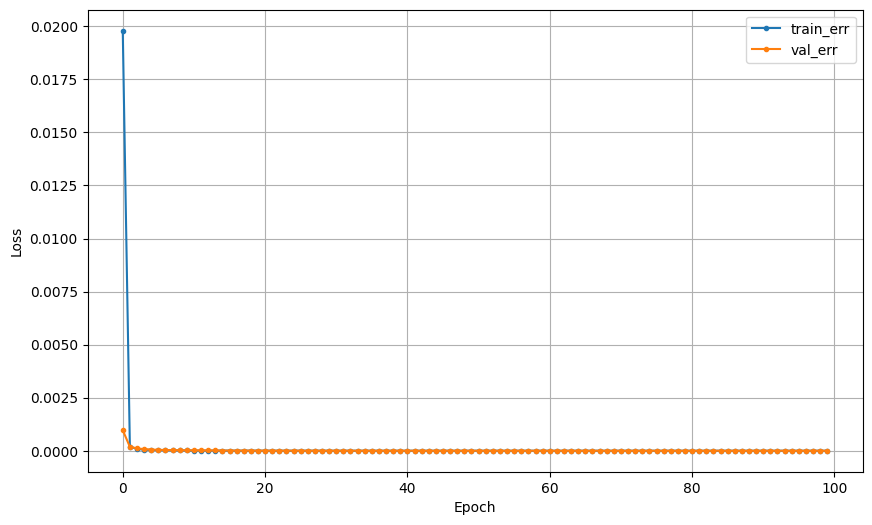

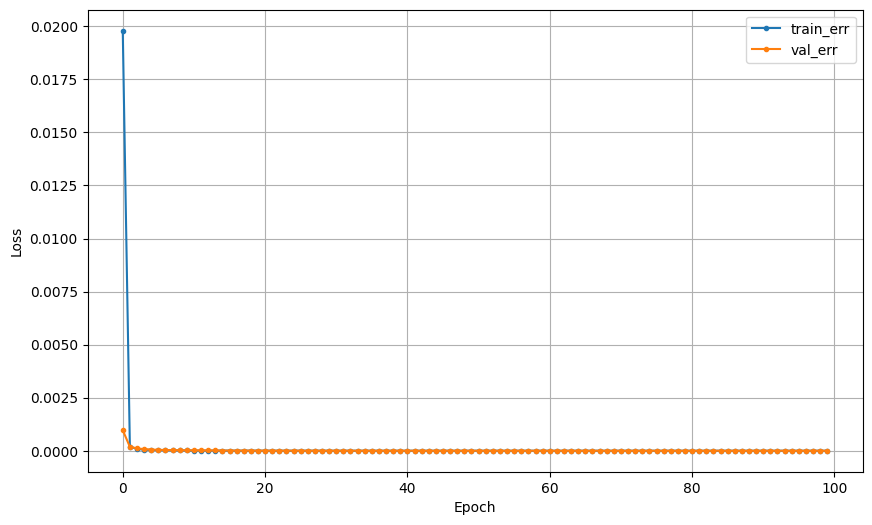

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[647   0]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

1.0
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[833   0]
 [  0 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

1.0


In [18]:
import tensorflow as tf, random, numpy as np, pickle

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)


input_layer=tf.keras.layers.Input(shape=(x_train.shape[1],))
dense_1=tf.keras.layers.Dense(128,activation='relu')(input_layer)
dense_2=tf.keras.layers.Dense(32,activation='relu')(dense_1)
output_layer=tf.keras.layers.Dense(1,activation='sigmoid')(dense_2)
model=tf.keras.models.Model(inputs=input_layer,outputs=output_layer)

optimzers=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimzers,loss='binary_crossentropy',metrics=['accuracy'])

er=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
cl=[er]

history=model.fit(x_train,y_train,validation_split=0.2,epochs=100,callbacks=cl)

dl_history_plot(history.history)

with open(path+'1_step_model_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
model.save(path+'1_step_model.keras')



from tensorflow.keras.models import load_model
model=load_model(path+'1_step_model.keras')

with open(path+'1_step_model_history.pkl', 'rb') as file:
    history = pickle.load(file)

dl_history_plot(history)

pred=model.predict(x_val)
pred=np.where(pred>0.5,1,0)
print(confusion_matrix(y_val,pred))
print(classification_report(y_val,pred))
print(accuracy_score(y_val,pred))


pred=model.predict(x_scaled_test)
pred=np.where(pred>0.5,1,0)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

#### 2) 모델2

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [19]:
traindata_static=traindata[traindata['Activity'].isin(['LAYING','SITTING','STANDING'])]
traindata_static=traindata_static.drop(columns='is_dynamic')
traindata_static.head()
testdata_statict=testdata[testdata['Activity'].isin(['LAYING','SITTING','STANDING'])]
testdata_statict=testdata_statict.drop(columns='is_dynamic')
testdata_statict.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.298895,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,STANDING


In [20]:
from sklearn.preprocessing import StandardScaler
static_scaler=StandardScaler()
x_scaled_static = pd.DataFrame(static_scaler.fit_transform(traindata_static.drop(columns='Activity')),columns=traindata_static.drop(columns='Activity').columns)
x_test_scaled_static = pd.DataFrame(static_scaler.transform(testdata_statict.drop(columns='Activity')),columns=traindata_static.drop(columns='Activity').columns)

# 스케일러 저장
joblib.dump(static_scaler, path + 'static_scaler.pkl')

y_static=traindata_static['Activity']
y_test_static=testdata_statict['Activity']


y_scaled_static=pd.get_dummies(y_static)
y_test_scaled_static=pd.get_dummies(y_test_static)

print(x_scaled_static.head())
print(x_test_scaled_static.head())
print(y_static.shape)
print(y_test_static.shape)


y_test_scaled_static
# LAYINH: 0
# SITTING: 1
# STANDING: 2

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.235591           0.143563           0.057594         -0.266169   
1          -0.142688          -0.016664           0.137155         -0.277956   
2           0.072671           0.028157          -0.024359         -0.448243   
3          -0.038452           0.314378          -0.281065         -0.330416   
4           0.166255           0.819950           1.533433         -0.082042   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.210148         -0.225391         -0.234368         -0.196952   
1         -0.475631         -0.402423         -0.260916         -0.449173   
2         -0.362664         -0.460564         -0.433769         -0.354951   
3          0.205199         -0.269878         -0.362759         -0.040053   
4          0.827163          1.411674         -0.115707          0.983727   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

,LAYING,SITTING,STANDING
0,False,True,False
1,False,False,True
3,False,True,False
4,False,False,True
6,False,False,True
...,...,...,...
1464,False,True,False
1465,False,True,False
1466,False,True,False
1467,False,False,True


In [21]:
from sklearn.model_selection import train_test_split as tts
x_train_static,x_val_static,y_train_static,y_val_static=tts(x_scaled_static,y_scaled_static,test_size=0.2,stratify=y_scaled_static,random_state=42)

In [22]:
data1=x_train_static.copy()
df_train_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_train_dict[f] = p_data
print(df_train_dict.keys())


data1=x_val_static.copy()
df_val_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_val_dict[f] = p_data
print(df_val_dict.keys())


data1=x_test_scaled_static.copy()
df_test_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_test_dict[f] = p_data
print(len(df_test_dict.keys()))


df_train=[]
for k,v in df_train_dict.items():
  df_train.append(v.values)
df_val=[]
for k,v in df_val_dict.items():
  df_val.append(v.values)
df_test=[]
for k,v in df_test_dict.items():
  df_test.append(v.values)

dict_keys(['tBodyAcc', 'tGravityAcc', 'tBodyAccJerk', 'tBodyGyro', 'tBodyGyroJerk', 'tBodyAccMag', 'tGravityAccMag', 'tBodyAccJerkMag', 'tBodyGyroMag', 'tBodyGyroJerkMag', 'fBodyAcc', 'fBodyAccJerk', 'fBodyGyro', 'fBodyAccMag', 'fBodyBodyAccJerkMag', 'fBodyBodyGyroMag', 'fBodyBodyGyroJerkMag', 'angle'])
dict_keys(['tBodyAcc', 'tGravityAcc', 'tBodyAccJerk', 'tBodyGyro', 'tBodyGyroJerk', 'tBodyAccMag', 'tGravityAccMag', 'tBodyAccJerkMag', 'tBodyGyroMag', 'tBodyGyroJerkMag', 'fBodyAcc', 'fBodyAccJerk', 'fBodyGyro', 'fBodyAccMag', 'fBodyBodyAccJerkMag', 'fBodyBodyGyroMag', 'fBodyBodyGyroJerkMag', 'angle'])
18


In [23]:
def Model_create(seed,df_dict):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)

  input_1 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[0]].shape[1],))
  input_2 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[1]].shape[1],))
  input_3 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[2]].shape[1],))
  input_4 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[3]].shape[1],))
  input_5 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[4]].shape[1],))
  input_6 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[5]].shape[1],))
  input_7 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[6]].shape[1],))
  input_8 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[7]].shape[1],))
  input_9 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[8]].shape[1],))
  input_10 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[9]].shape[1],))
  input_11 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[10]].shape[1],))
  input_12 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[11]].shape[1],))
  input_13 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[12]].shape[1],))
  input_14 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[13]].shape[1],))
  input_15 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[14]].shape[1],))
  input_16 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[15]].shape[1],))
  input_17 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[16]].shape[1],))
  input_18 = tf.keras.layers.Input(shape=(df_dict[featuresdata['sensor'].unique()[17]].shape[1],))

  x1_1 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_1)
  x1_2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_2)
  x1_3 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_3)
  x1_4 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_4)
  x1_5 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_5)
  x1_6 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_6)
  x1_7 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_7)
  x1_8 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_8)
  x1_9 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_9)
  x1_10 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_10)
  x1_11 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_11)
  x1_12 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_12)
  x1_13 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_13)
  x1_14 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_14)
  x1_15 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_15)
  x1_16 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_16)
  x1_17 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_17)
  x1_18 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(input_18)

  x2_1 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_1)
  x2_2 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_2)
  x2_3 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_3)
  x2_4 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_4)
  x2_5 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_5)
  x2_6 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_6)
  x2_7 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_7)
  x2_8 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_8)
  x2_9 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_9)
  x2_10 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_10)
  x2_11 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_11)
  x2_12 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_12)
  x2_13 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_13)
  x2_14 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_14)
  x2_15 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_15)
  x2_16 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_16)
  x2_17 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_17)
  x2_18 = tf.keras.layers.Dense(3, activation='relu', kernel_initializer='he_normal')(x1_18)

  concatenated = tf.keras.layers.Concatenate()([x2_1, x2_2, x2_3, x2_4, x2_5, x2_6, x2_7, x2_8, x2_9, x2_10,x2_11, x2_12, x2_13, x2_14, x2_15, x2_16, x2_17, x2_18])


  x3_1 = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal')(concatenated)
  x3_2 = tf.keras.layers.Dense(3, activation='softmax')(x3_1)

  model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4, input_5, input_6, input_7, input_8, input_9,
                                input_10, input_11, input_12, input_13, input_14, input_15, input_16, input_17, input_18],
                        outputs=[x3_2])
  model.summary()
  return model

In [24]:
seed=42
model = Model_create(seed,df_train_dict)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 21,241 (82.97 KB)

 Trainable params: 21,241 (82.97 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
optimizers=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizers,loss='categorical_crossentropy',metrics=['accuracy'])

er=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True,verbose=1)
rd=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.5,min_lr=0.000001)
cl=[er,rd]


history= model.fit(df_train,y_train_static,validation_split=0.2,batch_size=32,epochs=1000,callbacks=cl)

Epoch 1/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6793 - loss: 0.6565 - val_accuracy: 0.9247 - val_loss: 0.2155 - learning_rate: 0.0100
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9207 - loss: 0.1844 - val_accuracy: 0.9402 - val_loss: 0.1339 - learning_rate: 0.0100
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9651 - loss: 0.0851 - val_accuracy: 0.9421 - val_loss: 0.1698 - learning_rate: 0.0100
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9728 - loss: 0.0532 - val_accuracy: 0.9498 - val_loss: 0.1347 - learning_rate: 0.0100
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9890 - loss: 0.0308 - val_accuracy: 0.9266 - val_loss: 0.2599 - learning_rate: 0.0100
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9829 - loss: 0.0428 - val_accuracy: 0.9421 - val_loss: 0.1525 - learning_rate: 0.0100
Epoch 7/1000
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9875 - loss: 

In [26]:
with open(path+f'model_2_1_{seed}_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
model.save(path+f'model_2_1_{seed}.keras')

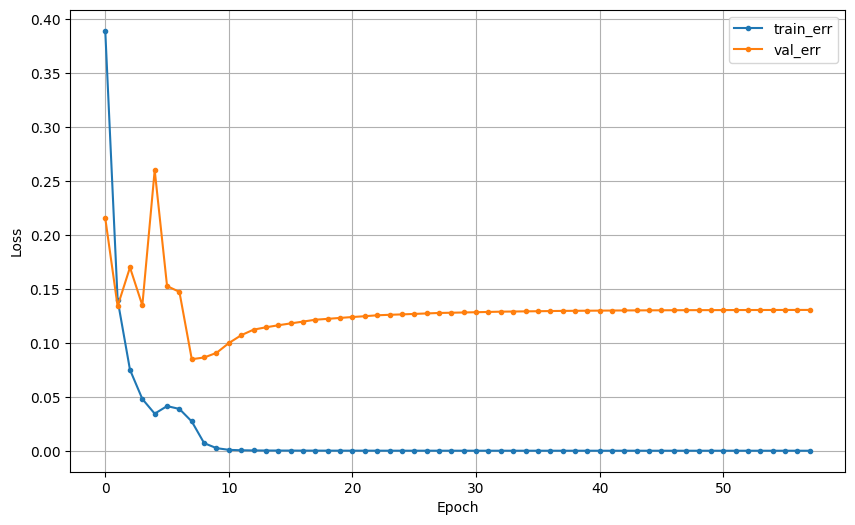

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
[[223   0   0]
 [  0 196  10]
 [  0   6 212]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.97      0.95      0.96       206
           2       0.95      0.97      0.96       218

    accuracy                           0.98       647
   macro avg       0.98      0.97      0.97       647
weighted avg       0.98      0.98      0.98       647

0.9752704791344667
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
[[292   0   0]
 [  0 241  13]
 [  0  14 273]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.95      0.95       254
           2       0.95      0.95      0.95       287

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833

0.9675870348139256


In [27]:
dl_history_plot(history.history)

pred=model.predict(df_val)
predict=np.argmax(pred,axis=1)
y_val_labels = np.argmax(y_val_static, axis=1)
print(confusion_matrix(y_val_labels,predict))
print(classification_report(y_val_labels,predict))
print(accuracy_score(y_val_labels,predict))


pred=model.predict(df_test)
predict=np.argmax(pred,axis=1)
y_val_labels = np.argmax(y_test_scaled_static, axis=1)
print(confusion_matrix(y_val_labels,predict))
print(classification_report(y_val_labels,predict))
print(accuracy_score(y_val_labels,predict))

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [28]:
traindata_dynamic=traindata[traindata['Activity'].isin(['WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])]
traindata_dynamic=traindata_dynamic.drop(columns='is_dynamic')
traindata_dynamic.head()
testdata_dynamic=testdata[testdata['Activity'].isin(['WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])]
testdata_dynamic=testdata_dynamic.drop(columns='is_dynamic')
testdata_dynamic.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
5,0.336801,0.010528,-0.057819,-0.435988,-0.126317,0.037931,-0.446406,-0.244650,-0.034606,-0.288437,...,0.115015,-0.351891,-0.174328,0.558749,0.664988,0.544573,-0.775712,0.187548,0.149686,WALKING
9,0.087902,-0.118993,-0.052787,-0.217817,-0.148752,0.079020,-0.294967,-0.165066,0.137718,0.070103,...,-0.535753,-0.842876,0.313940,0.577018,-0.968008,0.525585,-0.872144,0.186079,0.007999,WALKING_UPSTAIRS
16,0.267601,-0.032814,-0.113073,-0.290751,0.028228,-0.011504,-0.341515,0.043469,0.048429,-0.226421,...,-0.475586,-0.795217,-0.082706,0.206094,-0.917195,-0.365769,-0.616598,0.353675,0.087181,WALKING_UPSTAIRS
17,0.187920,-0.022493,-0.114320,-0.285203,-0.001438,0.163397,-0.339592,-0.134192,0.172202,0.093298,...,-0.381085,-0.806618,0.765867,-0.099255,0.815948,0.007978,-0.796053,0.199388,0.119815,WALKING


In [29]:
from sklearn.preprocessing import StandardScaler
dynamic_scaler=StandardScaler()
x_scaled_dynamic = pd.DataFrame(dynamic_scaler.fit_transform(traindata_dynamic.drop(columns='Activity')),columns=traindata_dynamic.drop(columns='Activity').columns)
x_test_scaled_dynamic = pd.DataFrame(dynamic_scaler.transform(testdata_dynamic.drop(columns='Activity')),columns=testdata_dynamic.drop(columns='Activity').columns)

# 스케일러 저장
joblib.dump(dynamic_scaler, path + 'dynamic_scaler.pkl')

y_dynamic=traindata_dynamic['Activity']
y_test_dynamic=testdata_dynamic['Activity']


y_scaled_dynamic=pd.get_dummies(y_dynamic)
y_test_scaled_dynamic=pd.get_dummies(y_test_dynamic)

print(x_scaled_dynamic.head())
print(x_test_scaled_dynamic.head())
print(y_dynamic.shape)
print(y_test_dynamic.shape)


y_test_scaled_dynamic

# WALKING: 0
# WALKING_DOWNSTAIRS: 1
# WALKING_UPSTAIRS: 2

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.190238          -0.524959          -0.789634         -0.326519   
1           1.576887           1.863636           4.206142          0.912285   
2           0.730484           0.953351           1.050471         -0.264751   
3          -2.032496          -0.400311           2.212130         -0.018851   
4           0.376298           0.788940           1.521092         -0.082521   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.090625         -0.592947         -0.289491          0.176821   
1         -0.562670         -0.796362          0.747481         -0.422844   
2          0.415627          1.066603         -0.274908          0.398516   
3         -0.593133         -0.194500         -0.009027         -0.689072   
4          0.836037          0.204979         -0.019798          0.597318   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
2,True,False,False
5,True,False,False
9,False,False,True
16,False,False,True
17,True,False,False
...,...,...,...
1459,False,False,True
1462,False,True,False
1463,False,True,False
1468,False,True,False


In [30]:
from sklearn.model_selection import train_test_split as tts
x_train_dynamic,x_val_dynamic,y_train_dynamic,y_val_dynamic=tts(x_scaled_dynamic,y_scaled_dynamic,test_size=0.2,stratify=y_scaled_dynamic,random_state=42)


In [31]:
data1=x_train_dynamic.copy()
df_train_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_train_dict[f] = p_data
print(df_train_dict.keys())


data1=x_val_dynamic.copy()
df_val_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_val_dict[f] = p_data
print(df_val_dict.keys())


data1=x_test_scaled_dynamic.copy()
df_test_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  data1.drop(columns_,axis=1,inplace=True)
  df_test_dict[f] = p_data
print(len(df_test_dict.keys()))


df_train=[]
for k,v in df_train_dict.items():
  df_train.append(v.values)
df_val=[]
for k,v in df_val_dict.items():
  df_val.append(v.values)
df_test=[]
for k,v in df_test_dict.items():
  df_test.append(v.values)

dict_keys(['tBodyAcc', 'tGravityAcc', 'tBodyAccJerk', 'tBodyGyro', 'tBodyGyroJerk', 'tBodyAccMag', 'tGravityAccMag', 'tBodyAccJerkMag', 'tBodyGyroMag', 'tBodyGyroJerkMag', 'fBodyAcc', 'fBodyAccJerk', 'fBodyGyro', 'fBodyAccMag', 'fBodyBodyAccJerkMag', 'fBodyBodyGyroMag', 'fBodyBodyGyroJerkMag', 'angle'])
dict_keys(['tBodyAcc', 'tGravityAcc', 'tBodyAccJerk', 'tBodyGyro', 'tBodyGyroJerk', 'tBodyAccMag', 'tGravityAccMag', 'tBodyAccJerkMag', 'tBodyGyroMag', 'tBodyGyroJerkMag', 'fBodyAcc', 'fBodyAccJerk', 'fBodyGyro', 'fBodyAccMag', 'fBodyBodyAccJerkMag', 'fBodyBodyGyroMag', 'fBodyBodyGyroJerkMag', 'angle'])
18


In [32]:
seed=42
model = Model_create(seed,df_train_dict)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_20            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_21            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_27            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_28            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_29            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_30            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 79)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 21,241 (82.97 KB)

 Trainable params: 21,241 (82.97 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
optimizers=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizers,loss='categorical_crossentropy',metrics=['accuracy'])

er=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True,verbose=1)
rd=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.5,min_lr=0.000001)
cl=[er,rd]


history= model.fit(df_train,y_train_dynamic,validation_split=0.2,batch_size=32,epochs=1000,callbacks=cl)


Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8264 - loss: 0.4323 - val_accuracy: 0.9764 - val_loss: 0.0761 - learning_rate: 0.0100
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9876 - loss: 0.0434 - val_accuracy: 0.9811 - val_loss: 0.0602 - learning_rate: 0.0100
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9895 - loss: 0.0255 - val_accuracy: 0.9882 - val_loss: 0.0330 - learning_rate: 0.0100
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0062 - val_accuracy: 0.9858 - val_loss: 0.0358 - learning_rate: 0.0100
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1091e-04 - val_accuracy: 0.9906 - val_loss: 0.0310 - learning_rate: 0.0100
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5918e-04 - val_accuracy: 0.9882 - val_loss: 0.0329 - learning_rate: 0.0100
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss

In [34]:
with open(path+f'model_2_2_{seed}_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
model.save(path+f'model_2_2_{seed}.keras')

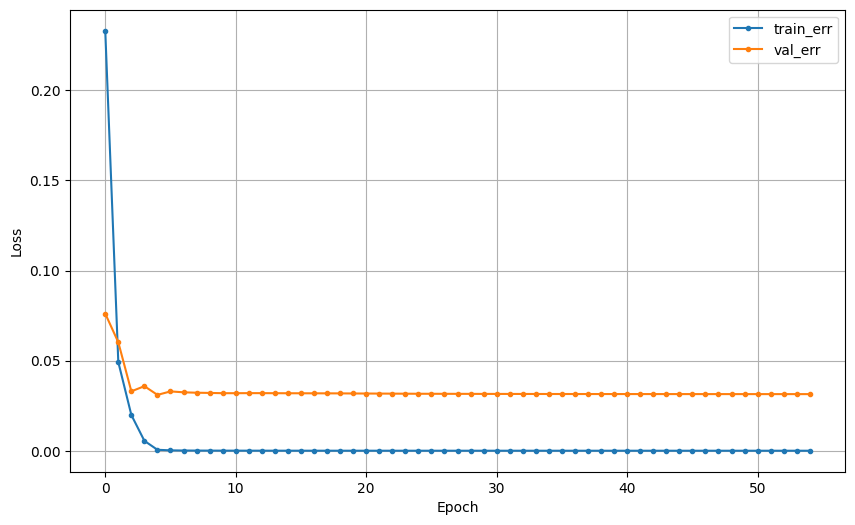

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
[[198   0   2]
 [  0 158   0]
 [  1   0 171]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       1.00      1.00      1.00       158
           2       0.99      0.99      0.99       172

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530

0.9943396226415094
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[[224   0   4]
 [  0 195   0]
 [  0   0 215]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       228
           1       1.00      1.00      1.00       195
           2       0.98      1.00      0.99       215

    accuracy                           0.99       638
   macro avg       0.99      0.99      0.99       638
weighted avg       0.99      0.99      0.99       638

0.9937304075235109


In [35]:
dl_history_plot(history.history)

pred=model.predict(df_val)
predict=np.argmax(pred,axis=1)
y_val_labels = np.argmax(y_val_dynamic, axis=1)
print(confusion_matrix(y_val_labels,predict))
print(classification_report(y_val_labels,predict))
print(accuracy_score(y_val_labels,predict))


pred=model.predict(df_test)
predict=np.argmax(pred,axis=1)
y_val_labels = np.argmax(y_test_scaled_dynamic, axis=1)
print(confusion_matrix(y_val_labels,predict))
print(classification_report(y_val_labels,predict))
print(accuracy_score(y_val_labels,predict))

### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [36]:
def data_preprocessing(scaler,static_scaler,dynamic_scaler,testdata,featuresdata):
  data=testdata.copy()
  data['is_dynamic']=np.where(testdata['Activity'].isin(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']),1,0)

  x_1=scaler.transform(data.drop(columns=['Activity','is_dynamic']))
  y_1=data['is_dynamic']

  data.loc[data['is_dynamic']==0,data.columns[:-2]] =  static_scaler.transform(data.loc[data['is_dynamic']==0,data.columns[:-2]])
  data.loc[data['is_dynamic']==1,data.columns[:-2]] =  dynamic_scaler.transform(data.loc[data['is_dynamic']==1,data.columns[:-2]])


  data1=data.copy()
  test_dict={}
  for f in featuresdata['sensor'].unique():
    columns_=[]
    for col in data1.columns:
      if '-' in col and f == col.split('-')[0]:
        columns_.append(col)
      elif f == 'angle' and f in col:
        columns_.append(col)
    p_data=data1[columns_]
    data1.drop(columns_,axis=1,inplace=True)
    test_dict[f] = p_data

  x_2=[]
  for k,v in test_dict.items():
    x_2.append(v.values)
  y_2=pd.get_dummies(data['Activity'])

  return x_1,y_1,x_2,y_2

In [37]:
x_1,y_1,x_2,y_2 = data_preprocessing(scaler,static_scaler,dynamic_scaler,testdata,featuresdata)

In [38]:
model_1 = load_model(path + f'1_step_model.keras')
model_2_1 = load_model(path + f'model_2_1_{seed}.keras')
model_2_2 = load_model(path + f'model_2_2_{seed}.keras')

#### 2) test 셋으로 예측하고 평가하기

In [39]:
# 데이터 전처리 (model1/2 입력 및 정답)
x_1,y_1,x_2,y_2=data_preprocessing(scaler,static_scaler,dynamic_scaler,testdata,featuresdata)

# model 1 예측 및 결과 저장
result_1 = model_1.predict(x_1)
result_1=np.where(result_1>0.5,1,0) ## pred_y_1

indices_0 = np.where(result_1.squeeze() == 0)[0]
indices_1 = np.where(result_1.squeeze() == 1)[0]

x_2_0 = [arr[indices_0] for arr in x_2] if len(indices_0) > 0 else None
x_2_1 = [arr[indices_1] for arr in x_2] if len(indices_1) > 0 else None


if x_2_0:
    pred_0 = model_2_1.predict(x_2_0) # pred_y_2_0
    pred_0 = np.argmax(pred_0, axis=1)

if x_2_1:
    pred_1 = model_2_2.predict(x_2_1) # pred_y_2_1
    pred_1 = np.argmax(pred_1, axis=1) + 3

result_2 = np.empty(shape=(len(result_1),), dtype=int)

if len(indices_0) > 0:
    result_2[indices_0] = pred_0
if len(indices_1) > 0:
    result_2[indices_1] = pred_1

accuracy_1 = accuracy_score(np.argmax(y_2, axis=1), result_2)
classification_report_1 = classification_report(np.argmax(y_2, axis=1), result_2)
confusion_matrix_1 = confusion_matrix(np.argmax(y_2, axis=1), result_2)

print(f'Accuracy: {accuracy_1}')
print(f'classification_report: {classification_report_1}')
print(f'confusion_matrix: {confusion_matrix_1}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Accuracy: 0.9789259007477906
classification_report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.95      0.95       254
           2       0.95      0.95      0.95       287
           3       1.00      0.98      0.99       228
           4       1.00      1.00      1.00       195
           5       0.98      1.00      0.99       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471

confusion_matrix: [[292   0   0   0   0   0]
 [  0 241  13   0   0   0]
 [  0  14 273   0   0   0]
 [  0   0   0 224   0   4]
 [  0   0   0   0 195   0]
 [  0   0   0   0   0 215]]


In [45]:
def p3_model(test_data, featuresdata) :

  # scaler, model load
  scaler = joblib.load(path + 'scaler.pkl')
  dynamic_scaler = joblib.load(path + 'dynamic_scaler.pkl')
  static_scaler = joblib.load(path + 'static_scaler.pkl')

  model_1 = load_model(path + f'1_step_model.keras')
  model_2_1 = load_model(path + f'model_2_1_42.keras')
  model_2_2 = load_model(path + f'model_2_2_42.keras')

  # 데이터 전처리 (model1/2 입력 및 정답)
  x_1,y_1,x_2,y_2=data_preprocessing(scaler,static_scaler,dynamic_scaler,testdata,featuresdata)

  # model 1 예측 및 결과 저장
  result_1 = model_1.predict(x_1)
  result_1=np.where(result_1>0.5,1,0) ## pred_y_1

  indices_0 = np.where(result_1.squeeze() == 0)[0]
  indices_1 = np.where(result_1.squeeze() == 1)[0]

  x_2_0 = [arr[indices_0] for arr in x_2] if len(indices_0) > 0 else None
  x_2_1 = [arr[indices_1] for arr in x_2] if len(indices_1) > 0 else None


  if x_2_0:
      pred_0 = model_2_1.predict(x_2_0) # pred_y_2_0
      pred_0 = np.argmax(pred_0, axis=1)

  if x_2_1:
      pred_1 = model_2_2.predict(x_2_1) # pred_y_2_1
      pred_1 = np.argmax(pred_1, axis=1) + 3

  result_2 = np.empty(shape=(len(result_1),), dtype=int)

  if len(indices_0) > 0:
      result_2[indices_0] = pred_0
  if len(indices_1) > 0:
      result_2[indices_1] = pred_1

  accuracy_1 = accuracy_score(np.argmax(y_2, axis=1), result_2)
  classification_report_1 = classification_report(np.argmax(y_2, axis=1), result_2)
  confusion_matrix_1 = confusion_matrix(np.argmax(y_2, axis=1), result_2)

  print('Accuracy:', accuracy_1)
  print('classification_report\n', classification_report_1)
  print('confusion_matrix\n', confusion_matrix_1)

In [46]:
p3_model(testdata,featuresdata)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Accuracy: 0.9789259007477906
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.95      0.95       254
           2       0.95      0.95      0.95       287
           3       1.00      0.98      0.99       228
           4       1.00      1.00      1.00       195
           5       0.98      1.00      0.99       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471

confusion_matrix
 [[292   0   0   0   0   0]
 [  0 241  13   0   0   0]
 [  0  14 273   0   0   0]
 [  0   0   0 224   0   4]
 [  0   0   0   0 195   0]
 [  0   0   0   0   0 215]]
